# Attention models for Time Series

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A notebook from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).


## Toy seq2seq task

For a start, have a look at the data produced by the following `gen_data` function.
The task at hand is to predict the output sequence from its corresponding input one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def make_series(positions, heights, shapes, size):
    series = np.zeros((size, ))
    for p, h, s in zip(positions, heights, shapes):
        if s == "r":
            series[p-5:p+5] = h
        else:
            series[p-5:p] = np.linspace(start=0., stop=h, num=5)
            series[p:p+5] = np.linspace(stop=0., start=h, num=5)
    return series.reshape((-1, 1))
    

def gen_data(n_samples, noise_level=.1):
    inputs, outputs = [], []
    shapes = np.array(["t", "r"] * 2)
    n_shapes = len(shapes)
    
    sz = 100
    region_width = sz // n_shapes
    
    for i in range(n_samples):
        np.random.shuffle(shapes)
        index_high_t = np.random.choice(np.where(shapes == "t")[0], size=1)[0]
        index_high_r = np.random.choice(np.where(shapes == "r")[0], size=1)[0]
        
        base_input_series = np.random.randn(sz, 1) * noise_level
        heights = []
        positions = []
        for idx_shape in range(n_shapes):
            pos = idx_shape * region_width + np.random.randint(low=5, high=region_width - 5)
            height = (.5 + np.random.rand(1)[0]) * 10.
            if idx_shape in [index_high_r, index_high_t]:
                height += 10.
            heights.append(height)
            positions.append(pos)
        input_series = np.random.randn(sz, 1) * noise_level + make_series(positions, heights, shapes, sz)
        
        normalized_heights = np.array(heights)
        for s in ["t", "r"]:
            normalized_heights[shapes == s] = normalized_heights[shapes == s].mean()
        output_series = np.random.randn(sz, 1) * noise_level + make_series(positions, normalized_heights, shapes, sz)
        inputs.append(input_series)
        outputs.append(output_series)
            
    return np.array(inputs), np.array(outputs)

np.random.seed(0)
inputs, outputs = gen_data(1000)
test_inputs, test_outputs = gen_data(10)

**Question #1.** Visualize the first 6 input/output pairs (each in one subfigure). Can you guess how the height of output motifs is computed?
Why would this data better suited to attention-based models than convolutional ones, for example?

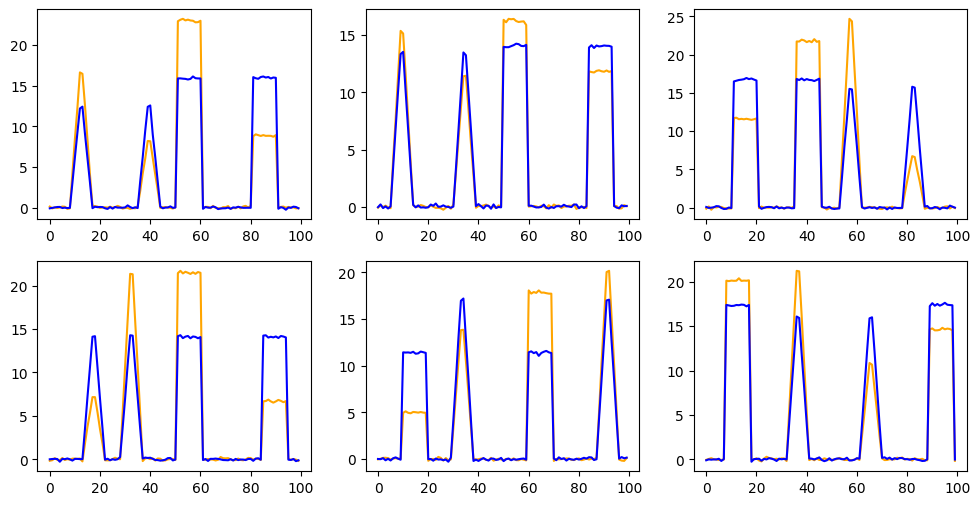

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(test_inputs[0], color='orange')
plt.plot(test_outputs[0], color='blue')

plt.subplot(2, 3, 2)
plt.plot(test_inputs[1], color='orange')
plt.plot(test_outputs[1], color='blue')

plt.subplot(2, 3, 3)
plt.plot(test_inputs[2], color='orange')
plt.plot(test_outputs[2], color='blue')

plt.subplot(2, 3, 4)
plt.plot(test_inputs[3], color='orange')
plt.plot(test_outputs[3], color='blue')

plt.subplot(2, 3, 5)
plt.plot(test_inputs[4], color='orange')
plt.plot(test_outputs[4], color='blue')

plt.subplot(2, 3, 6)
plt.plot(test_inputs[5], color='orange')
plt.plot(test_outputs[5], color='blue')

In [7]:
outputs.shape

(1000, 100, 1)

**Question #2.** Check how a model made of a stack of 5 convolutional layers (use 64 filters in all layers except the last one) performs on this task. What loss function should you use?

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=1, kernel_size=5, activation="linear", padding="same")
])
model.compile(optimizer="adam", loss="mse")
model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=100, batch_size = 50)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 39.9686 - val_loss: 9.8788
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8541 - val_loss: 8.3767
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.3273 - val_loss: 7.4202
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8146 - val_loss: 7.0109
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4557 - val_loss: 6.5691
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8262 - val_loss: 5.4406
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.4138 - val_loss: 2.9507
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2235 - val_loss: 2.2844
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5651 - val_loss: 1.6995
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2376 - val_loss: 1.7118
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1856 - val_loss: 1.6926
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


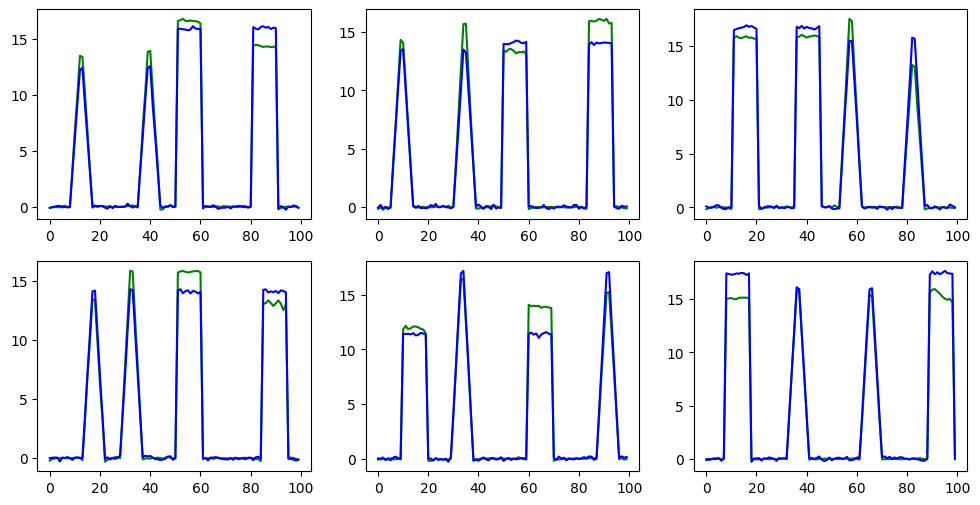

In [11]:
preds = model.predict(test_inputs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(preds[0], color='green')
plt.plot(test_outputs[0], color='blue')

plt.subplot(2, 3, 2)
plt.plot(preds[1], color='green')
plt.plot(test_outputs[1], color='blue')

plt.subplot(2, 3, 3)
plt.plot(preds[2], color='green')
plt.plot(test_outputs[2], color='blue')

plt.subplot(2, 3, 4)
plt.plot(preds[3], color='green')
plt.plot(test_outputs[3], color='blue')

plt.subplot(2, 3, 5)
plt.plot(preds[4], color='green')
plt.plot(test_outputs[4], color='blue')

plt.subplot(2, 3, 6)
plt.plot(preds[5], color='green')
plt.plot(test_outputs[5], color='blue')

**Question #3.** Below is the definition of a multi-head self attention layer class. Use this class to replace the 3rd convolution in your model above by a **single-head self-attention layer** that would output a 64-dimensional time series.

In [12]:
from keras.layers import MultiHeadAttention

class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)
    
    def build(self, x_shape):
        return super().build(query_shape=x_shape, value_shape=x_shape)
    
    def compute_output_shape(self, x_shape):
        return super().compute_output_shape(query_shape=x_shape, value_shape=x_shape)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)

attn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    MultiHeadSelfAttention(num_heads=1, key_dim=64),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=1, kernel_size=5, activation="linear", padding="same")
])
attn_model.compile(optimizer="adam", loss="mse")
attn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=100, batch_size = 50)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 47.7305 - val_loss: 18.8467
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 12.1837 - val_loss: 4.4187
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.6215 - val_loss: 2.5872
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.5515 - val_loss: 2.4068
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.2643 - val_loss: 1.9677
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.9783 - val_loss: 1.8206
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.7548 - val_loss: 1.5614
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.5292 - val_loss: 1.5139
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.3319 - val_loss: 1.1476
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.2229 - val_loss: 1.0501
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0616 - val_loss: 1.0786
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


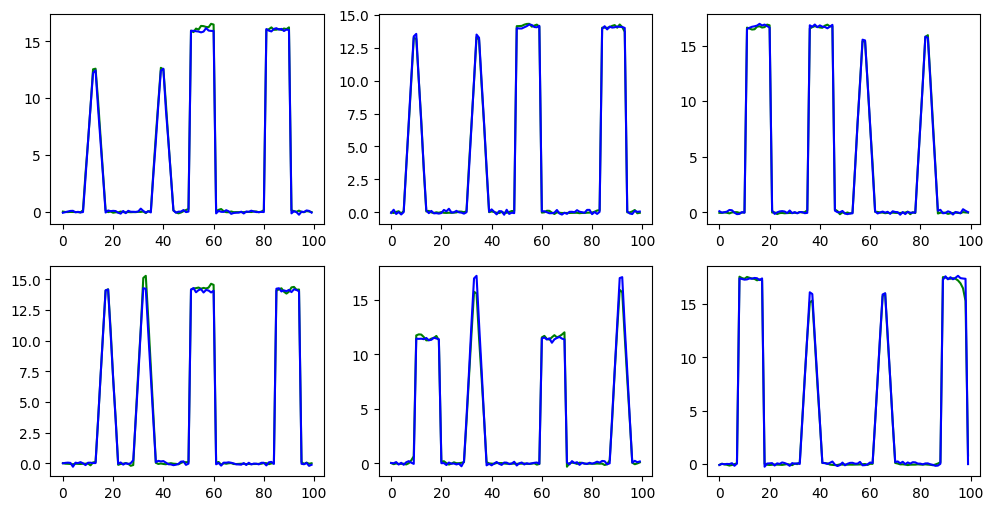

In [13]:
preds = attn_model.predict(test_inputs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(preds[0], color='green')
plt.plot(test_outputs[0], color='blue')

plt.subplot(2, 3, 2)
plt.plot(preds[1], color='green')
plt.plot(test_outputs[1], color='blue')

plt.subplot(2, 3, 3)
plt.plot(preds[2], color='green')
plt.plot(test_outputs[2], color='blue')

plt.subplot(2, 3, 4)
plt.plot(preds[3], color='green')
plt.plot(test_outputs[3], color='blue')

plt.subplot(2, 3, 5)
plt.plot(preds[4], color='green')
plt.plot(test_outputs[4], color='blue')

plt.subplot(2, 3, 6)
plt.plot(preds[5], color='green')
plt.plot(test_outputs[5], color='blue')

**Question #4.** Compare both models in terms of validation loss.

**Question #5.** Use test data for qualitative inspection of the produced outputs.

**Question #6.** Use the code below to visualize average attention scores for the first 3 test series.

In [ ]:
from keras.models import Sequential

def visualize_average_attention_scores(model, index_of_attention_layer, time_series):
    sub_model = Sequential(model.layers[:index_of_attention_layer])
    input_features = sub_model(time_series)
    att_layer = model.layers[index_of_attention_layer]
    output_tensor, weights = att_layer(input_features, return_attention_scores=True)

    plt.figure(figsize=(4*len(time_series), 4))
    for idx, ts in enumerate(time_series):
        plt.subplot(2, len(time_series), idx + 1)
        plt.plot(ts.ravel())
        plt.title("Input series")
        plt.subplot(2, len(time_series), len(time_series) + idx + 1)
        plt.plot(weights[idx, 0].numpy().mean(axis=0))
        plt.title("Average attention scores")
    plt.tight_layout()



## Attention models for Time Series Classification

In this section, you will design a model that relies on attention for the Trace dataset you already used in previous labs.

**Question #7.** Load the Trace dataset, merge training and test data and shuffle the resulting dataset.

**Question #8.** Using only convolutions, self-attention and dense layers, design a first neural network architecture for the task at hand. You will use 20% of the data as validation (see the `validation_split` argument of the `model.fit` function).

**Question #9.** Sub-class the `Conv1D` layer to implement a residual layer that would compute its output as:

$$\text{ResidualConv}(x) = x + \text{Conv}(x)$$

where $\text{Conv}(x)$ is a 1d convolution applied to the input series $x$.

Why would it make sense to use such a layer in place of a convolutional one?

**Question #10.** Replace convolutional layers by residual convolutional layers in your previous model and see if performance is improved.